In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d, gaussian_filter  
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, fbeta_score, precision_recall_curve,
    average_precision_score, auc, classification_report
)

In [7]:
import keras.backend as K
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, \
    BatchNormalization, Input, concatenate, Activation
from keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')
from inspect import signature

In [8]:
import h5py

In [9]:
def detrender_normalizer(light_flux):
  flux1 = light_flux
  flux2 = gaussian_filter(flux1, sigma=10)
  flux3 = flux1 - flux2
  flux3normalized = (flux3-np.mean(flux3)) / (np.max(flux3)-np.min(flux3))
  return flux3normalized

In [10]:
#Define a function for shuffeling in unison
def shuffle_in_unison(a, b):
  rng_state = np.random.get_state()
  np.random.shuffle(a)
  np.random.set_state(rng_state)
  np.random.shuffle(b)


Loaded model from disk
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3187, 8)           184       
                                                                 
 max_pooling1d (MaxPooling1  (None, 797, 8)            0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 797, 8)            32        
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 787, 16)           1424      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 197, 16)           0         
 g1D)                                                            
                                 

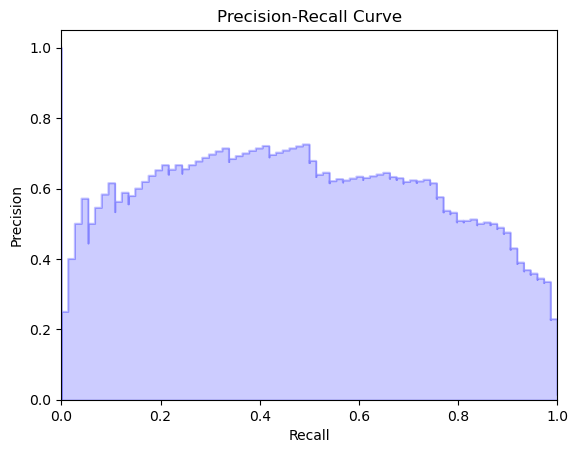

18/18 [==============================] - 0s 9ms/step
Validation for the test data:
col_0    0   1
row_0         
0      531  34
1        0  10
Accuracy: 0.941 Precision: 0.227 Recall: 1.000 F_beta: 0.595
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       565
           1       0.23      1.00      0.37        10

    accuracy                           0.94       575
   macro avg       0.61      0.97      0.67       575
weighted avg       0.99      0.94      0.96       575

Area under precision-recall-curve: 0.692


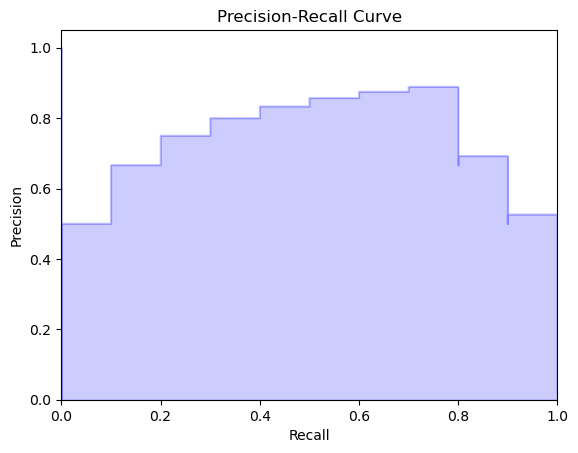

In [13]:
def main():
    # Upload and create model
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)  # load structure into a new model
    loaded_model.load_weights("model.h5")  # load weights into a new model
    print("Loaded model from disk")
    loaded_model.summary()

    # Converting the format from a dataframe to numpy arrays (matrices)
    # and defining x-values and y-values for both the test and training set
    print("Loading datasets...")
    train = pd.read_csv("Data/exoTrain.csv", encoding="ISO-8859-1")  # in dataframe format
    test = pd.read_csv("Data/exoTest.csv", encoding="ISO-8859-1")  # in dataframe format
    x_train = train.drop('LABEL', axis=1)
    x_test = test.drop('LABEL', axis=1)
    y_train = train.LABEL
    y_test = test.LABEL
    x_train = np.array(x_train)
    y_train = np.array(y_train).reshape((-1, 1)) - 1
    x_test = np.array(x_test)
    y_test = np.array(y_test).reshape((-1, 1)) - 1

    # Add extra positive examples of light curves by flipping them
    x_train = np.append(x_train, np.flip(x_train[0:37, :], axis=-1), axis=0)
    y_train = np.append(y_train, y_train[0:37]).reshape((-1, 1))
    x_test = np.append(x_test, np.flip(x_test[0:5, :], axis=-1), axis=0)
    y_test = np.append(y_test, y_test[0:5]).reshape((-1, 1))

    # Detrend the data sets
    x_train_p = detrender_normalizer(x_train)
    x_test_p = detrender_normalizer(x_test)

    # Scale each observation to zero mean and unit variance
    x_train = ((x_train - np.mean(x_train, axis=1).reshape(-1, 1)) / np.std(x_train, axis=1).reshape(-1, 1))
    x_test = ((x_test - np.mean(x_test, axis=1).reshape(-1, 1)) / np.std(x_test, axis=1).reshape(-1, 1))

    # Stack the zero mean unit variance normalized data and the detrended data
    x_train = np.stack([x_train, x_train_p], axis=2)
    x_test = np.stack([x_test, x_test_p], axis=2)

    # Make predictions for training data
    shuffle_in_unison(x_train, y_train)
    y_pred = loaded_model.predict(x_train)[:, 0]
    pred = np.empty((1, len(y_pred)), dtype=object)
    pred = np.where(y_pred >= 0.5, 1, 0)
    y_train = np.reshape(y_train, len(y_train))
    pred = np.reshape(pred, len(pred))

    # Create confusion matrix for training data
    print('Validation for training data:')
    conf_matrix = pd.crosstab(y_train, pred)
    print(conf_matrix)

    # Calculate precision and recall
    accuracy = accuracy_score(y_train, pred)
    precision = precision_score(y_train, pred)
    recall = recall_score(y_train, pred)
    fbeta = fbeta_score(y_train, pred, beta=1)
    print('Accuracy: %.3f Precision: %.3f Recall: %.3f F_beta: %.3f' % (accuracy, precision, recall, fbeta))

    # Create a precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_train, y_pred, pos_label=1)
    auc_pr = auc(recall, precision)
    print('Area under precision-recall-curve: %.3f' % (auc_pr))
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.show()

    # Make predictions for the test data
    shuffle_in_unison(x_test, y_test)
    y_pred = loaded_model.predict(x_test)[:, 0]
    pred = np.empty((1, len(y_pred)), dtype=object)
    pred = np.where(y_pred >= 0.5, 1, 0)
    y_test = np.reshape(y_test, len(y_test))
    pred = np.reshape(pred, len(pred))

    # Create a confusion matrix for the test data
    print('Validation for the test data:')
    conf_matrix = pd.crosstab(y_test, pred)
    print(conf_matrix)

    # Calculate precision and recall
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    fbeta = fbeta_score(y_test, pred, beta=2)
    print('Accuracy: %.3f Precision: %.3f Recall: %.3f F_beta: %.3f' % (accuracy, precision, recall, fbeta))
    print(classification_report(y_test, pred))
    # Create a precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred, pos_label=1)
    auc_pr = auc(recall, precision)
    print('Area under precision-recall-curve: %.3f' % (auc_pr))
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.show()

main()
